# Natural Language Processing - LSTM

## Recap

RNN stands for Recurrent Neural Network and primarily used for modelling of sequential data like Time Series, Text, etc.,

At the heart of an RNN is a layer made of memory cells. The most popular cell at the moment is the Long Short-Term Memory (LSTM) which maintains a cell state as 
well as a carry for ensuring that the signal (informationin the form of a gradient) is not lost as the sequence is processed. At each time step the LSTM considers 
the current word, the carry, and the cell state.

![LSTM](lstm2.png)

## Few LSTM Applications

1. Sentiment analysis
2. Sentence generation
3. Machine translation

## LSTM Structures

- Multi-Layer LSTM
- Bi-Directional LSTM
- LSTM with Attention

## Challenges with LSTM
1. Inappropriate model
    - Identify the problem: One-to-many, many-to-one etc.
    - Loss only for outputs that matter
    - Separate LSTMs for separate languages
2. High training loss
    - Model not expressive
    - Too few hidden nodes
    - Only one hidden layer
3. Overfitting
    - Model has too much freedom
        - Too many hidden nodes
        - Too many blocks
        - Too many layers

## Attention

Let's understand this through an example. 
Suppose someone gave us a book of machine learning and asked us to give information about LSTM. 
There are two ways of doing it, first, read the whole book and come back with the answer. 
Second, go to the index, find the ‘NLP’ chapter, go to the RNN part and read the part of LSTM.

_What do you think as the faster method ?_


Attention in neural networks is somewhat similar to what we find in humans. 
They focus on the high resolution in certain parts of the inputs while the rest of the input is in low resolution 

Checkout the animation which shows how simple seq-to-seq model works.

![Animation](NMT.gif)

We see that for each step of the encoder or decoder, RNN is processing its inputs and generating output for that time step. 
In each time step, RNN updates its hidden state based on inputs and previous outputs it has seen. 
In the animation, we see that the hidden state is actually the context vector we pass along to the decoder.

The context vector turned out to be problematic for these types of models. 
Models have a problem while dealing with long sentences. 
Or say they were facing the vanishing gradient problem in long sentences.

Attention was introduced as a solution. 
It highly improved the quality of machine translation as it allows the model to focus on the relevant part of the input sequence as needed.

![Attention Animation](NMT-ATTN.gif)

![Attention Decoder](ATTN-DECODER.gif)

## Transformer

All this is good, if I want to improve the performance further, I need to paralleize the execution. So how to parallelize the sequential data ?

This is where Transformer comes in as a solution. A paper called [“Attention Is All You Need”](https://arxiv.org/abs/1706.03762) published in 2017 
comes into the picture, it introduces an encoder-decoder architecture based on attention layers, termed as the transformer.

One main difference is that the input sequence can be passed parallelly so that GPU can be utilized effectively, and the speed of training can also be increased. 
And it is based on the multi-headed attention layer, vanishing gradient issue is also overcome by a large margin. The paper is based on the application of transformer 
on NMT(Neural Machine Translator).

Like for example in a translator made up of simple RNN we input our sequence or the sentence in a continuous manner, one word at a time to generate word embeddings. 
As every word depends on the previous word, its hidden state acts accordingly, so it is necessary to give one step at a time. 
While in transformer, it is not like that, we can pass all the words of a sentence simultaneously and determine the word embedding simultaneously.

**Architecture**
![Transformer](transformer.png)




## Text Generation using Bidirectional LSTM

Source:

1. https://www.analyticsvidhya.com/blog/2021/08/text-generation-using-bidirectional-lstm-a-walk-through-in-tensorflow/

In [2]:
# Dataset: Irish Lyrics

!wget --no-check-certificate "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt" -O irish-lyrics-eof.txt

--2022-03-11 06:01:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.003s  

2022-03-11 06:01:45 (26.1 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



In [1]:
# Import all the required libraries

import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

In [2]:
# load the data
data = open('irish-lyrics-eof.txt').read()
nlp = en_core_web_sm.load()
lemmatizer = WordNetLemmatizer()
DISABLE_PIPELINES = ["tok2vec", "parser", "ner", "textcat", "custom", "lemmatizer"]
stopwords = STOP_WORDS

In [18]:
data

'Come all ye maidens young and fair\nAnd you that are blooming in your prime\nAlways beware and keep your garden fair\nLet no man steal away your thyme\nFor thyme it is a precious thing\nAnd thyme brings all things to my mind\nnlyme with all its flavours, along with all its joys\nThyme, brings all things to my mind\nOnce I and a bunch of thyme\ni thought it never would decay\nThen came a lusty sailor\nWho chanced to pass my way\nAnd stole my bunch of thyme away\nThe sailor gave to me a rose\nA rose that never would decay\nHe gave it to me to keep me reminded\nOf when he stole my thyme away\nSleep, my child, and peace attend thee\nAll through the night\nGuardian angels God will send thee\nSoft the drowsy hours are creeping\nHill and dale in slumber sleeping\nI my loving vigil keeping\nWhile the moon her watch is keeping\nWhile the weary world is sleeping\nOer thy spirit gently stealing\nVisions of delight revealing\nBreathes a pure and holy feeling\nThough I roam a minstrel lonely\nMy t

In [7]:
class TextPreprocessor:
    def __init__(self, filters):
        self.filters = filters
    def preprocess_text(self, doc):
        tokens = [
            token
            for token in doc
            if not token.is_space and
               not token.like_email and
               not token.like_url and
               not token.is_stop and
               not token.is_punct and
               not token.like_num
        ]
        translation_table = str.maketrans('', '', self.filters)
        translated_tokens = [
            token.text.lower().translate(translation_table)
            for token in tokens
        ]
        lemmatized_tokens = [
            lemmatizer.lemmatize(token)
            for token in translated_tokens
            if len(token) > 1
        ]
        return lemmatized_tokens

In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
# spaCy preprocessing
FILTERS=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~'''
tp = TextPreprocessor(filters=FILTERS)
splitted_data = data.split('n')
texts = [
    tp.preprocess_text(doc)
    for doc in nlp.pipe(splitted_data, disable=DISABLE_PIPELINES)
]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1
# convert data into ngram sequences
input_sequences = []
for sentence in texts:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        input_sequences.append(token_list[:i+1])
max_sequence_len = max([len(x) for x in input_sequences])
# pad the data
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
)
# split data into features and target
features, labels = input_sequences[:,:-1], input_sequences[:,-1]
target = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [16]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=adam, 
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    features, 
    target, 
    epochs=100, 
    batch_size=64
)

Train on 3912 samples
Epoch 1/100
3912/3912 [==============================] - 4s 986us/sample - loss: 7.3069 - accuracy: 0.0125
Epoch 2/100
3912/3912 [==============================] - 2s 395us/sample - loss: 6.7169 - accuracy: 0.0181
Epoch 3/100
3912/3912 [==============================] - 2s 402us/sample - loss: 6.2864 - accuracy: 0.0291
Epoch 4/100
3912/3912 [==============================] - 2s 394us/sample - loss: 5.5178 - accuracy: 0.0726
Epoch 5/100
3912/3912 [==============================] - 2s 398us/sample - loss: 4.5092 - accuracy: 0.1401
Epoch 6/100
3912/3912 [==================

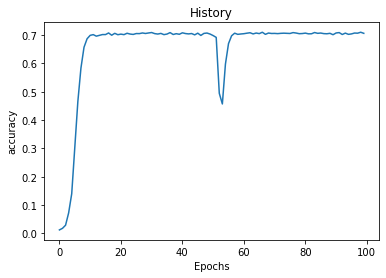

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title("History")
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.show()

In [20]:
inverted_word_index = {v: k for k, v in tokenizer.word_index.items()}
seed_text = "This is the good day of my life"
processed_text = tp.preprocess_text(nlp(seed_text))
processed_sentence = " ".join(processed_text)
next_words = 100
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([processed_sentence])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    processed_sentence += " " + inverted_word_index[predicted[0]]
print(processed_sentence)

good day life little flaxe ill road dow li maide dubli ge cheek lo li ve loved wish ru come ru ru lo ru loved lo li ye ru ru lo ge thy true love thy ge dear little shall agai ru thou soul shelter thou high tower raise thou heave thou true hush prettiest whiskey rose true rose true ba rose rose bloomi heave rose black rose rose bloomi heave true rose rose rose ill tell story row rose bloomi like primrose loved thy rosy love autum beyo gray heave life hush water harp lovd come mother house behi mi speak eri


## Bonus Links

1. [Attention and Transformed Networks - 1.5 Hr Video](https://youtu.be/OyFJWRnt_AY)
2. [https://jalammar.github.io/illustrated-transformer/](https://jalammar.github.io/illustrated-transformer/)
3. [https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)
4. [https://ai.googleblog.com/2017/06/accelerating-deep-learning-research.html](https://ai.googleblog.com/2017/06/accelerating-deep-learning-research.html)